# Declustering in Python for Engineers and Geoscientists

#### Hugo Solis,  Professor, Universidad Nacional Mayor de San Marcos (UNMSM) and Universidad Peruana de Ciencias Aplicadas - UPC

This exercise demonstrates demonstrates the cell-based declustering  in Python using  GeostatsPy Functions - by Michael Pyrcz.
A datasheet from CSV File containing Gold and Copper grade in a 2D space are used.

Contacts: hsoliss@unmsm.edu.pe - pcgmhsol@upc.edu.pe 

# This exercise demonstrates the cell-based declustering approach in Python with wrappers and reimplimentation of GSLIB methods. The steps include:
1. visualize the location map of the original exhaustive
2. visualize the new declustered distribution along with the scatter plot of declustered weight vs. cell size.

Followig are some GeostastPy Functions - by Michael Pyrcz, maintained at https://git.io/fNgR7

In [1]:
# A set of functions to provide access to GSLIB in Python.
# GSLIB executables: nscore.exe, declus.exe, gam.exe, gamv.exe, vmodel.exe, kb2d.exe & sgsim.exe must be in the working directory 
# note, since I have now rewritten nscore, gam, gamv and kb2d one can just use these in Python
# available in the geostatspy package.
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
image_type = 'tif'; dpi = 600

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name 

# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods, displayed and as image file
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')  
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods (version for subplots)
def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):  
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods (version for subplots)
def locmap_st(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0   
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im           

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods(version for subplots)
def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)  
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods(version for subplots)
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev): 
    mean = np.average(array)
    stdev = np.std(array)  
    array = (tstdev/stdev)*(array - mean) + tmean
    return(array)   

def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var    

# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,var,output_file):
    import os
    import numpy as np 
    
    nug = var['nug']
    nst = var['nst']; it1 = var['it1']; cc1 = var['cc1']; azi1 = var['azi1']; hmaj1 = var['hmaj1']; hmin1 = var['hmin1'] 
    it2 = var['it2']; cc2 = var['cc2']; azi2 = var['azi2']; hmaj2 = var['hmaj2']; hmin2 = var['hmin2']     
    max_range = max(hmaj1,hmaj2) 
    hmn = hsiz * 0.5   
    hctab = int(max_range/hsiz)*2 + 1

    sim_array = np.random.rand(nx,ny)

    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
    file.write(str(it1) + " " + str(cc1) + " " +str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
    file.write(str(it2) + " " + str(cc2) + " " +str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")  
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array[0])

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    ny = xx.shape[0]
    nx = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[iy,ix])
        y.append(yy[iy,ix])
        v.append(array[iy,ix])
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

GSLIB subfunctions required by the GSLIB functions converted to Python. All are available with geostatspy.

In [2]:

import math
import numpy as np
import numpy.linalg as linalg
from numba import jit

def dlocate(xx,iis,iie,x):
    from bisect import bisect
    n = len(xx)
    if iie <= iis:
        iis = 0; ie = n-1
    array = xx[iis:iie-1]  # this is accounting for swith to 0,...,n-1 index
    j = bisect(array,x)
    return j

def dsortem(ib,ie,a,iperm,b=0,c=0,d=0,e=0,f=0,g=0,h=0):
    a = a[ib:ie]
    inds = a.argsort()
    a = np.copy(a[inds]) # deepcopy forces pass to outside scope
    if(iperm == 1):
        return a
    b_slice = b[ib:ie]
    b = b_slice[inds]    
    if iperm == 2:
        return a,b
    c_slice = c[ib:ie]
    c = c_slice[inds]    
    if iperm == 3:
        return a, b, c
    d_slice = d[ib:ie]
    d = d_slice[inds]    
    if iperm == 4:
        return a, b, c, d
    e_slice = e[ib:ie]
    e = e_slice[inds]    
    if iperm == 5:
        return a, b, c, d, e 
    f_slice = f[ib:ie]
    f = f_slice[inds]
    if iperm == 6:
        return a, b, c, d, e, f 
    g_slice = g[ib:ie]
    g = g_slice[inds]
    if iperm == 7:
        return a, b, c, d, e, f, h     
    h_slice = h[ib:ie]
    h = h_slice[inds]
    return a, b, c, d, e, f, h

def gauinv(p):
    lim = 1.0e-10; p0 = -0.322232431088; p1 = -1.0; p2 = -0.342242088547
    p3 = -0.0204231210245; p4 = -0.0000453642210148; q0 = 0.0993484626060
    q1 = 0.588581570495; q2 = 0.531103462366; q3 = 0.103537752850; q4 = 0.0038560700634

# Check for an error situation:
    if p < lim:
        xp = -1.0e10
        return xp
    if p > (1.0-lim):
        xp =  1.0e10
        return xp    

# Get k for an error situation:
    pp = p
    if p > 0.5: pp = 1 - pp
    xp   = 0.0
    if p == 0.5: 
        return xp

# Approximate the function:
    y  = np.sqrt(np.log(1.0/(pp*pp)))
    xp = float(y + ((((y*p4+p3)*y+p2)*y+p1)*y+p0) /
            ((((y*q4+q3)*y+q2)*y+q1)*y+q0) )
    if float(p) == float(pp): 
        xp = -xp
    return xp

def gcum(x):
    z = x
    if z < 0:  
        z = -z
    t= 1./(1.+ 0.2316419*z)
    gcum = t*(0.31938153   + t*(-0.356563782 + t*(1.781477937 +
           t*(-1.821255978 + t*1.330274429))))
    e2= 0.0
    
# standard deviations out gets treated as infinity:
    if z <= 6: 
        e2 = np.exp(-z*z/2.0)*0.3989422803
    gcum = 1.0- e2 * gcum
    if x >= 0.0: 
        return gcum
    gcum = 1.0 - gcum
    return gcum

def dpowint(xlow,xhigh,ylow,yhigh,xval,pwr):
    EPSLON = 1.0e-20
    if (xhigh-xlow) < EPSLON:
        dpowint = (yhigh+ylow)/2.0
    else:
        dpowint = ylow + (yhigh-ylow)*(((xval-xlow)/(xhigh-xlow))**pwr)
    return dpowint

@jit(nopython=True) # all NumPy array operations included in this function for precompile with NumBa
def setup_rotmat(c0,nst,it,cc,ang,PMX):
    DTOR=3.14159265/180.0; EPSLON=0.000000; PI=3.141593
# The first time around, re-initialize the cosine matrix for the
# variogram structures:
    rotmat = np.zeros((4,nst))
    maxcov = c0
    for js in range(0,nst):
        azmuth = (90.0-ang[js])*DTOR
        rotmat[0,js] =  math.cos(azmuth)
        rotmat[1,js] =  math.sin(azmuth)
        rotmat[2,js] = -1*math.sin(azmuth)
        rotmat[3,js] =  math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + PMX
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov
     
@jit(nopython=True) # all NumPy array operations included in this function for precompile with NumBa
def cova2(x1,y1,x2,y2,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov):
    DTOR=3.14159265/180.0; EPSLON=0.000000; PI=3.141593
                      
# Check for very small distance:
    dx = x2-x1
    dy = y2-y1
#    print(dx,dy)
    if (dx*dx+dy*dy) < EPSLON:
        cova2 = maxcov
        return cova2

# Non-zero distance, loop over all the structures:
    cova2 = 0.0
    for js in range(0,nst):
#        print(js)
#        print(rotmat)
# Compute the appropriate structural distance:
        dx1 = (dx*rotmat[0,js] + dy*rotmat[1,js])
        dy1 = (dx*rotmat[2,js] + dy*rotmat[3,js])/anis[js]
        h   = math.sqrt(max((dx1*dx1+dy1*dy1),0.0))
        if it[js] == 1:

# Spherical model:
            hr = h/aa[js]
            if hr < 1.0: 
                cova2 = cova2 + cc[js]*(1.-hr*(1.5-.5*hr*hr))
            elif it[js] == 2:
                
# Exponential model:
                cova2 = cova2 + cc[js]*np.exp(-3.0*h/aa[js])
            elif it[js] == 3:

# Gaussian model:
                hh=-3.0*(h*h)/(aa[js]*aa[js])
                cova2 = cova2 +cc[js]*np.exp(hh)
            elif it[js] == 4:

# Power model:
                cov1  = PMX - cc[js]*(h**aa[js])
                cova2 = cova2 + cov1      
    return cova2

def ksol_numpy(neq,a,r):    # using Numpy methods
    a = a[0:neq*neq]             # trim the array
    a = np.reshape(a,(neq,neq))  # reshape to 2D
    ainv = linalg.inv(a)         # invert matrix
    r = r[0:neq]                 # trim the array
    s = np.matmul(ainv,r)        # matrix multiplication
    return s

Here's the translation of declus to Python (Michael Pyrcz, Jan. 2019 - let me know if you find any issues).

In [3]:
import numpy as np
import pandas as pd

# GSLIB's DECLUS program (Deutsch and Journel, 1998) converted from the original Fortran to Python 
# by Michael Pyrcz, the University of Texas at Austin (Jan, 2019)
# note this was simplified to 2D only
def declus(df,xcol,ycol,vcol,iminmax,noff,ncell,cmin,cmax):
# Parameters - consistent with original GSLIB    
# df - Pandas DataFrame with the spatial data
# xcol, ycol - name of the x and y coordinate columns
# vcol - name of the property column
# iminmax - 1 / True for use cell size with max decluster mean, 0 / False for declustered mean minimizing cell size
# noff - number of offsets
# ncell - number of cell sizes
# cmin, cmax - min and max cell size
#
# Load Data and Set Up Arrays
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    v = df[vcol].values
    wt = np.zeros(nd)
    wtopt = np.ones(nd)
    index = np.zeros(nd, np.int32)
    xcs_mat = np.zeros(ncell+2) # we use 1,...,n for this array
    vrcr_mat = np.zeros(ncell+2) # we use 1,...,n for this array
    anisy = 1.0   # hard code the cells to 2D isotropic
    roff = float(noff)
    
# Calculate extents    
    xmin = np.min(x); xmax = np.max(x)
    ymin = np.min(y); ymax = np.max(y)
      
# Calculate summary statistics
    vmean = np.mean(v)
    vstdev = np.std(v)
    vmin = np.min(v)
    vmax = np.max(v)
    xcs_mat[0] = 0.0; vrcr_mat[0] = vmean; vrop = vmean # include the naive case
    print('There are ' + str(nd) + ' data with:')
    print('   mean of      ' + str(vmean) + ' ')
    print('   min and max  ' + str(vmin) + ' and ' + str(vmax))
    print('   standard dev ' + str(vstdev) + ' ')
    
# define a "lower" origin to use for the cell sizes:
    xo1 = xmin - 0.01
    yo1 = ymin - 0.01

# define the increment for the cell size:
    xinc = (cmax-cmin) / ncell
    yinc = xinc

# loop over "ncell+1" cell sizes in the grid network:
    ncellx = int((xmax-(xo1-cmin))/cmin)+1
    ncelly = int((ymax-(yo1-cmin*anisy))/(cmin))+1
    ncellt = ncellx*ncelly 
    cellwt = np.zeros(ncellt)
    xcs =  cmin - xinc
    ycs = (cmin*anisy) - yinc

# MAIN LOOP over cell sizes:
    for lp in range(1,ncell+2):   # 0 index is the 0.0 cell, note n + 1 in Fortran
        xcs = xcs + xinc
        ycs = ycs + yinc
        
# initialize the weights to zero: 
        wt.fill(0.0)

# determine the maximum number of grid cells in the network:
        ncellx = int((xmax-(xo1-xcs))/xcs)+1
        ncelly = int((ymax-(yo1-ycs))/ycs)+1
        ncellt = float(ncellx*ncelly)

# loop over all the origin offsets selected:
        xfac = min((xcs/roff),(0.5*(xmax-xmin)))
        yfac = min((ycs/roff),(0.5*(ymax-ymin)))
        for kp in range(1,noff+1):
            xo = xo1 - (float(kp)-1.0)*xfac
            yo = yo1 - (float(kp)-1.0)*yfac

# initialize the cumulative weight indicators:
            cellwt.fill(0.0)
    
# determine which cell each datum is in:
            for i in range(0,nd):
                icellx = int((x[i] - xo)/xcs) + 1
                icelly = int((y[i] - yo)/ycs) + 1
                icell  = icellx + (icelly-1)*ncellx  
                index[i] = icell
                cellwt[icell] = cellwt[icell] + 1.0


# The weight assigned to each datum is inversely proportional to the
# number of data in the cell.  We first need to get the sum of weights
# so that we can normalize the weights to sum to one:
            sumw = 0.0
            for i in range(0,nd):
                ipoint = index[i]
                sumw   = sumw + (1.0 / cellwt[ipoint])
            sumw = 1.0 / sumw
                
# Accumulate the array of weights (that now sum to one):
            for i in range(0,nd):
                ipoint = index[i]
                wt[i] = wt[i] + (1.0/cellwt[ipoint])*sumw

# End loop over all offsets:

# compute the weighted average for this cell size:
        sumw  = 0.0
        sumwg = 0.0
        for i in range(0,nd):
            sumw  = sumw + wt[i]
            sumwg = sumwg + wt[i]*v[i]
        vrcr = sumwg / sumw
        vrcr_mat[lp] = vrcr
        xcs_mat[lp] = xcs

# see if this weighting is optimal:
        if iminmax and vrcr < vrop or not iminmax and vrcr > vrop or ncell == 1:
            best = xcs
            vrop = vrcr
            wtopt = wt.copy()   # deep copy

# END MAIN LOOP over all cell sizes:

# Get the optimal weights:
    sumw = 0.0
    for i in range(0,nd):
        sumw = sumw + wtopt[i]
    wtmin = np.min(wtopt)
    wtmax = np.max(wtopt)
    facto = float(nd) / sumw
    wtopt = wtopt * facto
    return wtopt,xcs_mat,vrcr_mat

In [4]:
import numpy as np
import pandas as pd

# GSLIB's NSCORE program (Deutsch and Journel, 1998) converted from the original Fortran to Python 
# by Michael Pyrcz, the University of Texas at Austin (Jan, 2019)
def nscore(df,vcol,wcol=0,ismooth=0,dfsmooth=0,smcol=0,smwcol=0):
# Parameters - consistent with original GSLIB    
# df - Pandas DataFrame with the spatial data
# vcol - name of the variable column
# wcol (optional) - name of the weigth column, if not included assumes equal weighting
# ismooth - if 1 then use a reference distribution 
# dfsmooth - Pandas DataFrame required if reference distribution is used
# smcol, smwtcol - reference distribution property and weight required if reference distribution is used
#
# Set constants
    np.random.seed(73073)
    pwr = 1.0                         # interpolation power, hard coded to 1.0 in GSLIB
    EPSILON = 1.0e-20

# Decide which file to use for establishing the transformation table:
    if ismooth == 1: 
        nd = len(dfsmooth)
        vr = dfsmooth[smcol].values
        wt_ns = np.ones(nd)
        if smwcol != 0:
            wt_ns = dfsmooth[smwcol].values 
    else:
        nd = len(df)
        vr = df[vcol].values
        wt_ns = np.ones(nd)
        if wcol != 0:
            wt_ns = df[wcol].values
    twt = np.sum(wt_ns)

# Sort data by value:
    istart = 0
    iend   = nd
    vr, wt_ns = dsortem(istart,iend,vr,2,wt_ns)

# Compute the cumulative probabilities and write transformation table
    wtfac = 1.0/twt
    oldcp = 0.0
    cp    = 0.0
    for j in range(istart,iend):  
        w = wtfac*wt_ns[j]
        cp = cp + w
        wt_ns[j] = (cp + oldcp)/2.0
        vrrg = gauinv(wt_ns[j])
        vrg = float(vrrg)
        oldcp =  cp

# Now, reset the weight to the normal scores value:
        wt_ns[j] = vrg
    
# Normal Scores Transform:

    nd_trans = len(df)
    ns = np.zeros(nd_trans)
    val = df[vcol].values
    for i in range(0,nd_trans): 
        vrr = val[i] + np.random.rand() * EPSILON

# Now, get the normal scores value for "vrr" 
        j = dlocate(vr,1,nd,vrr)
        j   = min(max(1,j),(nd-1))
        ns[i] = dpowint(vr[j],vr[j+1],wt_ns[j],wt_ns[j+1],vrr,pwr)
        #print(vrr,ns[i])
    return ns, vr, wt_ns

# Set the working directory
It is good to sort out files in special location in our PC and whatever you do running Python,  You don't lose files and to simplify subsequent read and writes (avoid including the full address each time). Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable Path.
Example: 
Base folder:
D:/Gslib90  Base folder containing  GSLIB executables
../Data  SubDirectory for Input files 
../Output SuDirectory for Input files 

In [5]:
os.chdir("D:/Gslib90")                                   # set the working directory
path=os.getcwd()
print(path)

D:\Gslib90


# Example Declustering
Working with CSV File from our Data Directory  and reading as a Pandas DataFrame and convert it to standard normal distributed. 
It is possible to add weights next and then consider a reference distribution after that

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pygeostat as gs # Libreria Geoestadistica
import os

In [7]:
path=os.getcwd()
filename=path+"\data\ISAACS.CSV"
print(filename)
tablaDF = pd.read_csv(filename)  #tablaDF=gs.read_csv(filename)
tablaDF.head()
#tablaDF.columns[0]

D:\Gslib90\data\ISAACS.CSV


,ID,xlocation,ylocation,zlocation,rocktype,gold,copper,gold1
0,1,11,8,0,2,NaN,NaN,0.713
1,2,8,30,0,2,NaN,NaN,0.666
2,3,9,48,0,2,224.199997,NaN,0.712
3,4,8,68,0,2,434.399994,NaN,0.235
4,5,9,90,0,2,412.100006,NaN,0.415


# Choosing XYZ coordinates and especific VR (column)  from our Datafile to apply Declustering
 Cleaning Non Data values it good practice when Data analisys are followed in Geoestastiscs 

In [8]:
vrColName='gold'
dataVR=tablaDF.filter(items=['xlocation','ylocation','zlocation',vrColName])
dataVR.dropna(inplace=True)  # 1D Output File Including XYZ Location 
dataVR.head()

,xlocation,ylocation,zlocation,gold
2,9,48,0,224.199997
3,8,68,0,434.399994
4,9,90,0,412.100006
5,10,110,0,587.200012
6,9,129,0,192.300003


<ipython-input-1-8b433dba995f>:74: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")


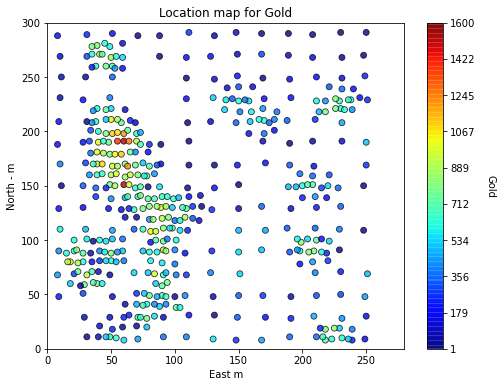

In [21]:
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = 280; ymax = 300                                           # calculate the extent of model
seed = 74073                                                     # random number seed  for stochastic simulation    
#cmap = plt.cm.RdYlBu
vmin = 1; vmax = 1600; cmap = plt.cm.jet                           # color min and max and using the jet color map
vcol='gold'
locmap(dataVR,'xlocation','ylocation',vcol,xmin,xmax,ymin,ymax,vmin,vmax,"Location map for Gold","East m",'North - m',"Gold",cmap,"F1.tif")
    


# Declustering data
Let's apply the Python translation of declus, the GSLIB cell-based declustering program, to this sample set. The declus method has the following parameters (df,xcol,ycol,vcol,cmin,cmax,cnum,bmin) where df, xcol, ycol, vcol are the DataFrame with the data and the columns with x, y and feature, cmin and cmax are the minimum and maximum cell sizes, cnum is the number of cell sizes (discretization of this range) and bmin is true for selecting the cell size that minimizes the declustered mean (set to false for the cell that maximizes the declustered mean).


In [52]:
# declus(df,xcol,ycol,vcol,iminmax,noff,ncell,cmin,cmax)
# Parameters - consistent with original GSLIB    
# df - Pandas DataFrame with the spatial data
# xcol, ycol - name of the x and y coordinate columns
# vcol - name of the property column
# iminmax - 1 / True for use cell size with max decluster mean, 0 / False for declustered mean minimizing cell size
# noff - number of offsets
# ncell - number of cell sizes
# cmin, cmax - min and max cell size
wts,cell_sizes,averages = declus(dataVR,'xlocation','ylocation','gold',iminmax=1,noff=1,ncell=20,cmin=5,cmax=120)

There are 448 data with:
   mean of      457.8877004416741 
   min and max  2.0999999 and 1528.099976
   standard dev 290.71263128560145 


In [30]:
cell_sizes, averages

(array([ 0.        ,  5.        ,  5.46666667,  5.93333333,  6.4       ,
         6.86666667,  7.33333333,  7.8       ,  8.26666667,  8.73333333,
         9.2       ,  9.66666667, 10.13333333, 10.6       , 11.06666667,
        11.53333333, 12.        ]),
 array([457.88770044, 457.88770044, 445.27682537, 434.60637889,
        432.83099963, 437.74263235, 423.32464886, 416.12821216,
        415.78450646, 409.8011582 , 409.13425409, 395.86202682,
        383.38670479, 390.60639234, 383.79994276, 372.65416637,
        365.3503998 ]))

Let's visualize the declustered output. We should check out the porosity distribution naive and declustered, the distribution and location map of the delucstered weights and the plot of cell size vs. declustered mean.

In [27]:
import scipy.stats

dataVR['wts'] = wts            # add the weights to the sample data
dataVR.head()

,xlocation,ylocation,zlocation,gold,wts
2,9,48,0,224.199997,1.641026
3,8,68,0,434.399994,1.641026
4,9,90,0,412.100006,0.410256
5,10,110,0,587.200012,1.641026
6,9,129,0,192.300003,1.641026


<ipython-input-1-8b433dba995f>:89: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")


DescribeResult(nobs=448, minmax=(0.277399380804954, 4.715789473684218), mean=1.0000000000000016, variance=1.024368669876005, skewness=2.2756984671329885, kurtosis=5.195995611454043)


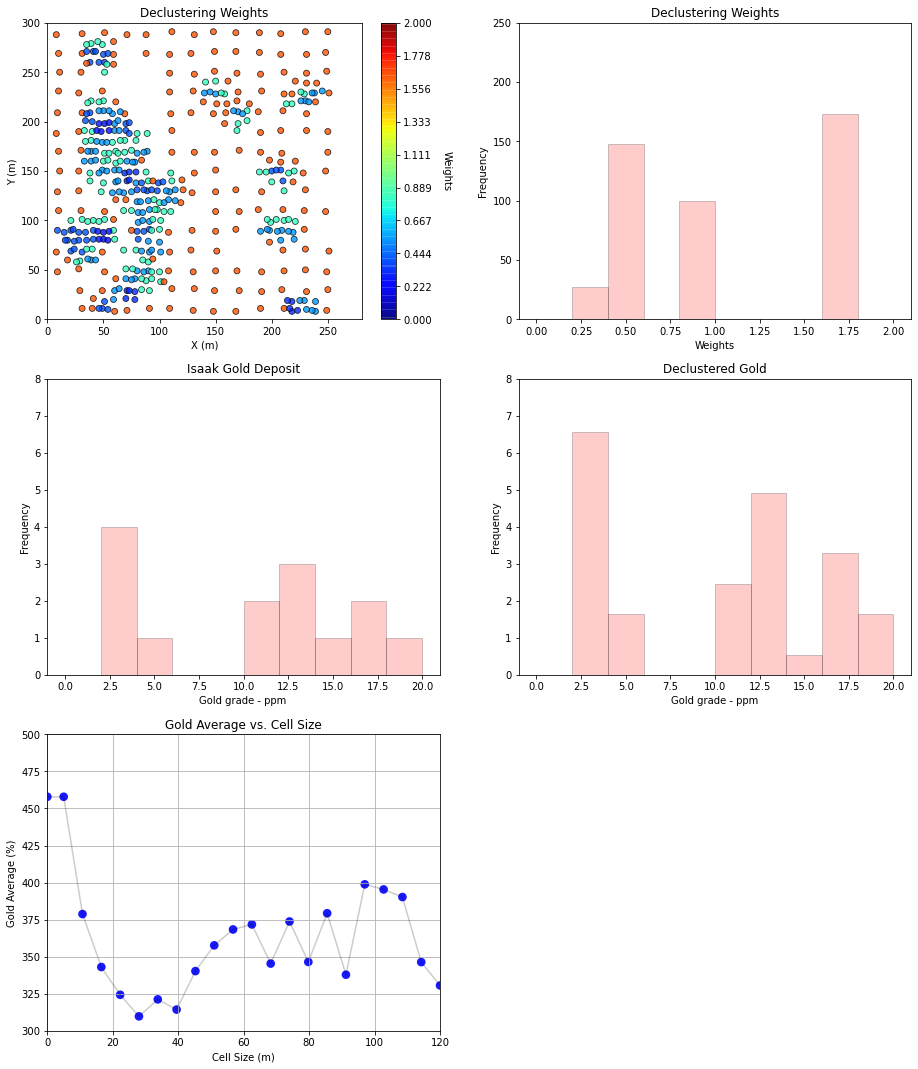

In [54]:
plt.subplot(321)
locmap_st(dataVR,'xlocation','ylocation','wts',xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplot(322)
hist_st(dataVR['wts'],0.0,2.0,log=False,cumul=False,bins=10,weights=None,xlabel="Weights",title="Declustering Weights")
plt.ylim(0.0,250)

plt.subplot(323)
hist_st(dataVR['gold'],0.0,20.0,log=False,cumul=False,bins=10,weights=None,xlabel="Gold grade - ppm ",title="Isaak Gold Deposit")
plt.ylim(0.0,8)

plt.subplot(324)
hist_st(dataVR['gold'],0.0,20.0,log=False,cumul=False,bins=10,weights=dataVR['wts'],xlabel="Gold grade - ppm",title="Declustered Gold")
plt.ylim(0.0,8)

plt.subplot(325)
plt.scatter(cell_sizes,averages, c = "b", marker='o', s=75,alpha = 0.9, edgecolors = "none")
plt.plot(cell_sizes,averages,c = "black",alpha = 0.2)
plt.grid()
plt.xlabel('Cell Size (m)')
plt.ylabel('Gold Average (%)')
plt.title('Gold Average vs. Cell Size')
plt.ylim(300,500)
plt.xlim(0,120)

print(scipy.stats.describe(wts))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.5, wspace=0.2, hspace=0.2)
plt.show()